# Multiple Linear Regression

## A model to predict the uniaxial compressive strength (UCS) of rocks from their mineral and geometric properties

This was a continous assessment requirement for my final module. The task was to select a dataset and perform multiple linear regression analysis using R. I am using it to train myself how to build a Juptyer notebook.

The data was taken from http://users.stat.ufl.edu/~winner/datasets.html

As well as the dependent variable UCS, 8 potential predictor variables are available:

%Quartz, %Plagaoclase, %K.feldspar, %Hornblende, Grain size (mm), Grain area (mm^2), Aspect Ratio, Shape Factor 


## Load and Activate R

The first step was to load and activate the IRKernel which I did following this tutorial

https://www.datacamp.com/community/blog/jupyter-notebook-r#gs.z0gxLNc

## Import the data and start exploring

In [1]:
#import the data and take a look
link <- 'http://users.stat.ufl.edu/~winner/data/rockstrength.csv'
rocks <- read.csv(link)

I'm going to get rid of the id column straight away as it is not nessecary in R 

In [315]:
rocks <- rocks[2:10] 

Check the data types (which are propably all numerical, but need to make sure)

In [316]:
str(rocks)

'data.frame':	30 obs. of  9 variables:
 $ UCS   : num  100.6 112 117.5 100.9 94.5 ...
 $ quartz: num  40.3 47.1 45.4 41.3 33.8 37.2 40 39.1 44.2 35.1 ...
 $ plag  : num  9.98 8.5 9.1 7.72 4.1 7.4 5.44 5.1 5 5.51 ...
 $ kfds  : num  17 15 16.2 11 14 ...
 $ hb    : num  21.6 23 24 18.9 16 ...
 $ gs    : num  0.031 0.025 0.022 0.044 0.043 0.046 0.035 0.032 0.032 0.056 ...
 $ ga    : num  754 491 380 1520 1452 ...
 $ sf    : num  0.594 0.612 0.628 0.571 0.575 0.499 0.606 0.585 0.615 0.572 ...
 $ ar    : num  0.63 0.612 0.628 0.667 0.662 0.663 0.685 0.683 0.68 0.639 ...


All numercial, but very different scales

Next up - have a look at the dependent variable (UCS). Does the assumption of normality hold?


	Shapiro-Wilk normality test

data:  rocks$UCS
W = 1, p-value = 0.4


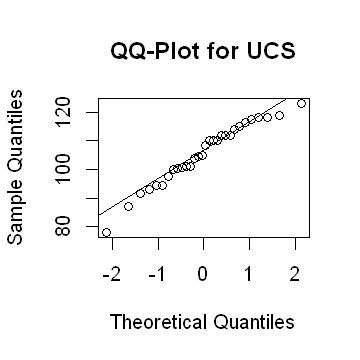

In [317]:
library(repr)
options(repr.plot.width=3, repr.plot.height=3) #recale the plot to a reasonable size
qqnorm(rocks$UCS, main = 'QQ-Plot for UCS')
qqline(rocks$UCS)
shapiro.test(rocks$UCS)

Since the QQ-plot is roughly a straight and the p-value from the Shapiro-Wilk test is > 0.05, there is no reason to query the assumption of a normally distributed dependent variable.

The plot produced by the notebook was really big though, so I rescaled using the 'repr' package

Next I want to check the relationships between the dependent variable and the predictors and also the relationships between the predictors. 

In [318]:
cor(rocks)

,UCS,quartz,plag,kfds,hb,gs,ga,sf,ar
UCS,1.000,0.520,0.3233,0.2671,0.694,-0.8535,-0.8537,0.7454,-0.1306
quartz,0.520,1.000,0.3671,-0.1382,0.182,-0.3401,-0.4047,0.2171,-0.1796
plag,0.323,0.367,1.0000,0.0299,0.144,-0.1297,-0.1707,0.2501,-0.6496
kfds,0.267,-0.138,0.0299,1.0000,0.628,-0.4543,-0.4074,0.0932,-0.3269
hb,0.694,0.182,0.1443,0.6277,1.000,-0.7200,-0.6642,0.5053,-0.2292
gs,-0.854,-0.340,-0.1297,-0.4543,-0.720,1.0000,0.9845,-0.6677,0.0899
ga,-0.854,-0.405,-0.1707,-0.4074,-0.664,0.9845,1.0000,-0.6475,0.0933
sf,0.745,0.217,0.2501,0.0932,0.505,-0.6677,-0.6475,1.0000,-0.0953
ar,-0.131,-0.180,-0.6496,-0.3269,-0.229,0.0899,0.0933,-0.0953,1.0000


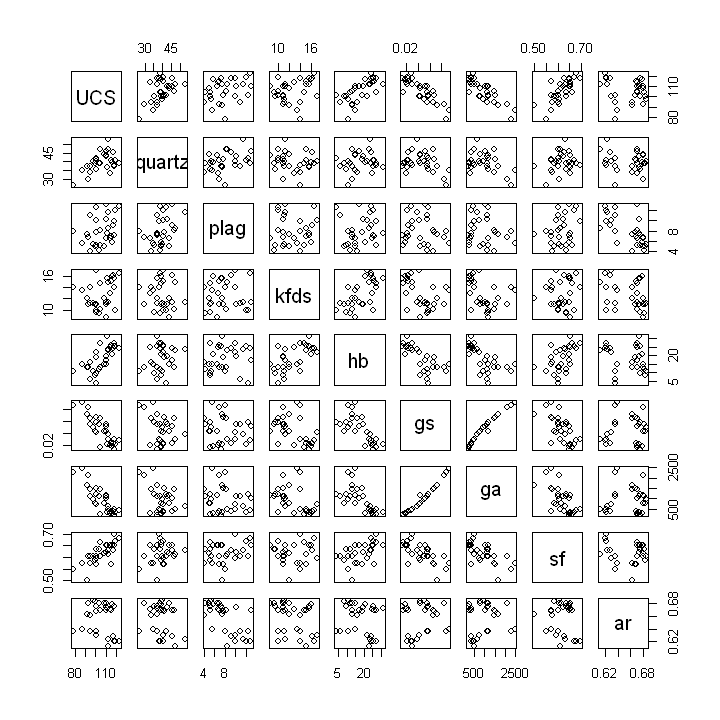

In [319]:
options(repr.plot.width=6, repr.plot.height=6)
pairs(rocks)

The most striking observation is that two of the variables 'gs' and 'ga' are very highly correlated with each other (cor > 0.98). 

'gs' is grain size and 'ga' is grain area. Since they are closely related attributes and so highly correlated, I am just going to get rid of one of them  -  'ga'. 

In [320]:
rocks <- rocks[-7]

And re-run the pairs() function to take another look

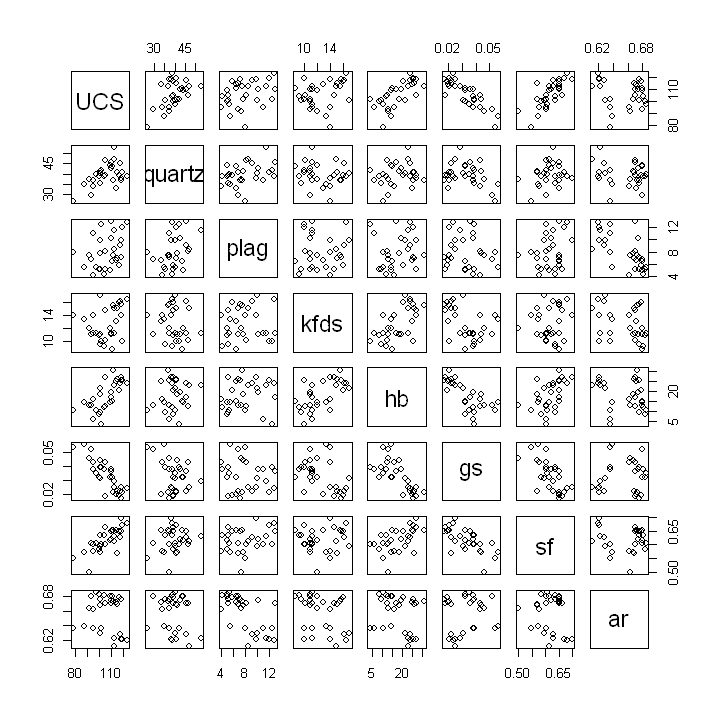

In [321]:
pairs(rocks)

Lots of promising correlation between UCS and the predictors, particularily quartz, hb, gs and sf. But also lots of correlation between the predictors themselves, which means PCA is a good next step.

## PCA

In [322]:
rocks_scaled <- as.data.frame(scale(rocks[2:8])) #normalize so all predictor variables are on the same scale
rocks.pca <- prcomp(rocks_scaled) # run pca
summary(rocks.pca) #ouptut from pca

Importance of components:
                        PC1   PC2   PC3    PC4    PC5    PC6    PC7
Standard deviation     1.69 1.249 1.113 0.8172 0.5167 0.4869 0.3944
Proportion of Variance 0.41 0.223 0.177 0.0954 0.0381 0.0339 0.0222
Cumulative Proportion  0.41 0.633 0.810 0.9058 0.9439 0.9778 1.0000

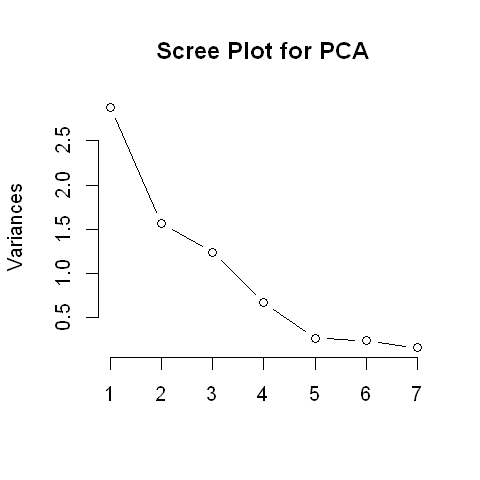

In [323]:
options(repr.plot.width=4, repr.plot.height=4)
screeplot(rocks.pca, type="lines", main = 'Scree Plot for PCA')

From the PCA output, the first 3 components account for over 80% of the variation in the dataset and each account for the 
variance of > 1 variable (scree-plot) so I will add them to the rocks data frame and attempt some models.

With PCA, it's a good idea to understand which variables are contributing to each PCA element and to what extend using a biplot.

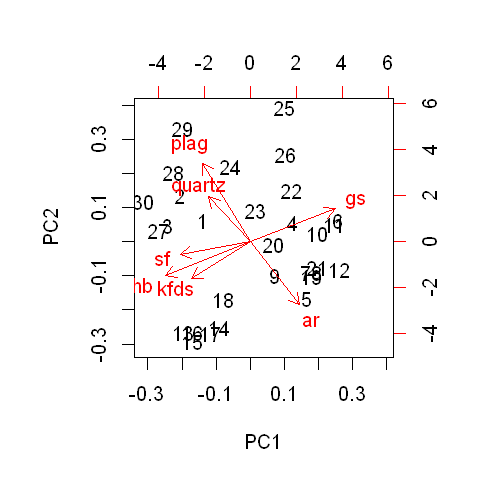

In [324]:
biplot(rocks.pca)

what does the biplot tell us

In [325]:
#add PC1, 2 and 3 to the data.frame
rocks_with_PCA <- data.frame(rocks, rocks.pca$x[,1:3])

# Models

First, just try the 3 PCA variables

In [326]:
#just try everything model
model <- lm(UCS ~ PC1 + PC2 + PC3, data = rocks_with_PCA)
summary(model)


Call:
lm(formula = UCS ~ PC1 + PC2 + PC3, data = rocks_with_PCA)

Residuals:
    Min      1Q  Median      3Q     Max 
-12.452  -2.195   0.995   2.071   6.960 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  105.577      0.748  141.23  < 2e-16 ***
PC1           -5.285      0.449  -11.78  6.3e-12 ***
PC2           -0.735      0.609   -1.21     0.24    
PC3            3.820      0.683    5.59  7.1e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.09 on 26 degrees of freedom
Multiple R-squared:  0.868,	Adjusted R-squared:  0.853 
F-statistic: 57.2 on 3 and 26 DF,  p-value: 1.39e-11


Coefficient for PC2 is not statistically significant, so I'm going to remove it and re-run the model with just PC1 and PC3

In [327]:
model <- lm(UCS ~ PC1 + PC3, data = rocks_with_PCA)
summary(model)


Call:
lm(formula = UCS ~ PC1 + PC3, data = rocks_with_PCA)

Residuals:
    Min      1Q  Median      3Q     Max 
-10.987  -2.609   0.747   2.125   7.582 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  105.577      0.754  140.05  < 2e-16 ***
PC1           -5.285      0.452  -11.68  4.6e-12 ***
PC3            3.820      0.689    5.55  7.0e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.13 on 27 degrees of freedom
Multiple R-squared:  0.861,	Adjusted R-squared:  0.851 
F-statistic: 83.6 on 2 and 27 DF,  p-value: 2.69e-12


Using just PC1 and PC3 gives a decent model that accounts for 85% of the variation. 
Definetly worth checking out the diagnostic plots and cross-validating.

### Diagnostic Plots for PC1 + PC3 model

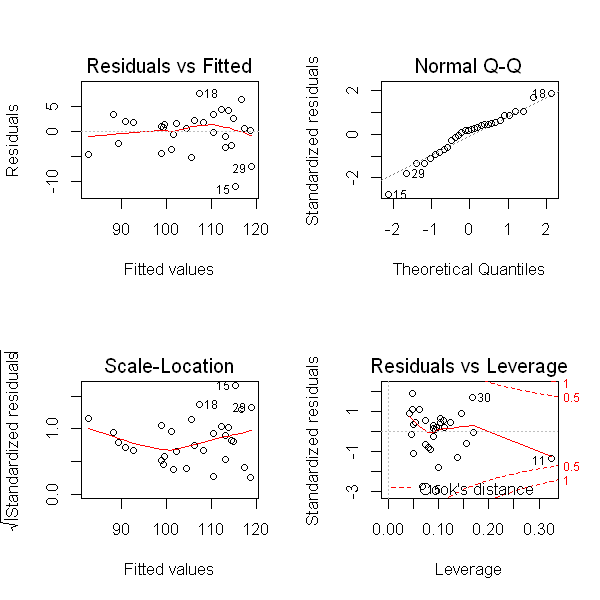

In [328]:
options(repr.plot.width=5, repr.plot.height=5)
par(mfrow = c(2,2))
plot(model)

Not too bad but two things strike me (i) Observation 11 has a relatively high Cook's distance compared to the other points and approaching 0.5
(ii) Observation 15 is out of trend, not massively but worth checking out it's effect on the model

### Cross validation for model PC1 + PC3

Since there are only 30 observations, I'm going to try the 'leave one out' approach to cross validation
and calculate the RMSD (root mean squared deviation) from the output.

Note: I came across a bug in the DAAG package for the cv.lm function when both printit and plotit are set to false. Have found a fix (see https://stackoverflow.com/questions/40700867/cvlm-daag-setting-printit-false-causes-an-issue-object-sumss-not-found). You may need to force an update of the DAAG package to get the following code to work or set either printit or plotit to TRUE in the cv.lm code

In [329]:
library(lattice)
library(DAAG)
LOOcv_PC1_PC3= cv.lm(rocks_with_PCA, model, m =30, printit = FALSE, plotit = FALSE)
RMSD_PC1_PC3<-sqrt(mean((LOOcv_PC1_PC3$cvpred-LOOcv_PC1_PC3$UCS)^2))
round(RMSD_PC1_PC3, 4)

[1] 4.37

To assess the influence/impact of Observations 11 and 15 on the model, I am going to re-run it with (i) just Obs 11 removed (ii) just Obs 15 removed and (iii) both Obs 11 and 15 removed.

Since I'm going to repeat the RMSD calculation a few times, I'm going to put it into a function

In [330]:
func_RMSD <- function(cv_output){
   rmsd <- sqrt(mean((cv_output$cvpred - cv_output$UCS)^2)) #hardwired with UCS as function is only for use in this notebook
    return (rmsd)
}

#### Obs 11 removed


Call:
lm(formula = UCS ~ PC1 + PC3, data = rocks_with_PCA[-11, ])

Residuals:
   Min     1Q Median     3Q    Max 
-10.70  -2.68   0.75   2.05   7.21 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  105.802      0.760  139.20  < 2e-16 ***
PC1           -5.100      0.465  -10.96    3e-11 ***
PC3            3.280      0.785    4.18  0.00029 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.06 on 26 degrees of freedom
Multiple R-squared:  0.83,	Adjusted R-squared:  0.817 
F-statistic: 63.4 on 2 and 26 DF,  p-value: 9.94e-11


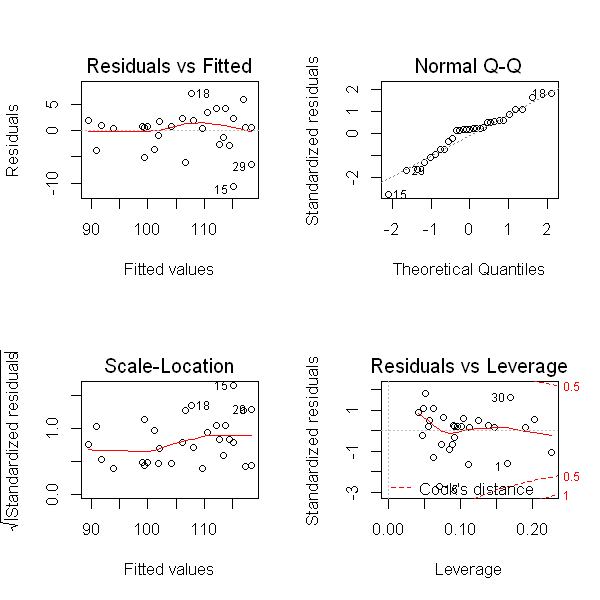

In [331]:
model_no11 <- lm(UCS ~ PC1 + PC3, data = rocks_with_PCA[-11,])
summary(model_no11)
par(mfrow = c(2,2))
plot(model_no11)
LOOcv_PC1_PC3_no11 <- cv.lm(rocks_with_PCA[-11,] , model_no11, m =29, printit = FALSE, plotit = FALSE)
RMSD_no11 <- func_RMSD(LOOcv_PC1_PC3_no11)



#### Obs 15 removed


Call:
lm(formula = UCS ~ PC1 + PC3, data = rocks_with_PCA[-15, ])

Residuals:
   Min     1Q Median     3Q    Max 
-7.929 -2.097  0.716  1.851  7.099 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  105.970      0.663  159.88  < 2e-16 ***
PC1           -5.508      0.397  -13.87  1.6e-13 ***
PC3            3.956      0.596    6.63  4.9e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.57 on 26 degrees of freedom
Multiple R-squared:   0.9,	Adjusted R-squared:  0.892 
F-statistic:  117 on 2 and 26 DF,  p-value: 9.9e-14


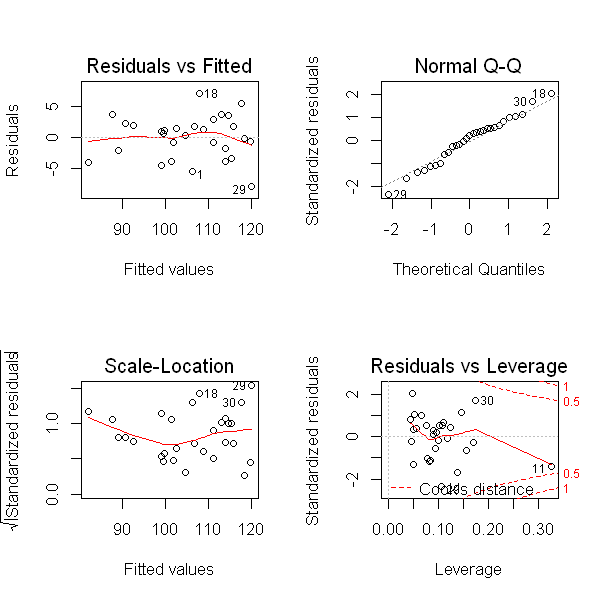

In [332]:
model_no15 <- lm(UCS ~ PC1 + PC3, data = rocks_with_PCA[-15,])
summary(model_no15)
par(mfrow = c(2,2))
plot(model_no15)
LOOcv_PC1_PC3_no15 <- cv.lm(rocks_with_PCA[-15,] , model_no15, m =29, printit = FALSE, plotit = FALSE)
RMSD_no15 <- func_RMSD(LOOcv_PC1_PC3_no15)

#### Obs 11 and 15 removed


Call:
lm(formula = UCS ~ PC1 + PC3, data = rocks_with_PCA[-c(11, 15), 
    ])

Residuals:
   Min     1Q Median     3Q    Max 
-7.347 -2.356  0.728  1.720  6.775 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  106.161      0.664  159.79  < 2e-16 ***
PC1           -5.338      0.408  -13.09  1.1e-12 ***
PC3            3.471      0.678    5.12  2.8e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.5 on 25 degrees of freedom
Multiple R-squared:  0.878,	Adjusted R-squared:  0.869 
F-statistic: 90.4 on 2 and 25 DF,  p-value: 3.61e-12


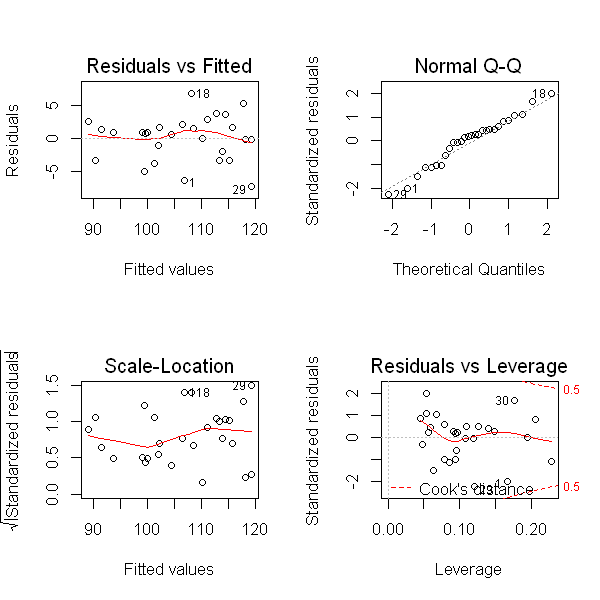

In [333]:
model_no11_no15 <- lm(UCS ~ PC1 + PC3, data = rocks_with_PCA[-c(11, 15),])
summary(model_no11_no15)
par(mfrow = c(2,2))
plot(model_no11_no15)
LOOcv_PC1_PC3_no11_no15 <- cv.lm(rocks_with_PCA[-c(11, 15),], model_no11, m =28, printit = FALSE, plotit = FALSE)
RMSD_no11_no15 <- func_RMSD(LOOcv_PC1_PC3_no11_no15)



In [334]:
#make a data frame summarizing Adj R2, RSE and F to compare the 4 models
adj_r2 <- c(summary(model)$r.squared, summary(model_no15)$r.squared,summary(model_no11)$r.squared,
            summary(model_no11_no15)$r.squared)
RSE <- c(summary(model)$sigma, summary(model_no15)$sigma,summary(model_no11)$sigma,summary(model_no11_no15)$sigma)
RMSD_all <- c(RMSD_PC1_PC3, RMSD_no15, RMSD_no11, RMSD_no11_no15)

In [335]:
model_comparison <- data.frame(adj_r2, RSE, RMSD_all)
row.names(model_comparison) <- c("pca all", "pca no 15", "pca no 11", "pca no 11 and 15")
model_comparison

,adj_r2,RSE,RMSD_all
pca all,0.861,4.13,4.37
pca no 15,0.900,3.57,3.82
pca no 11,0.830,4.06,4.27
pca no 11 and 15,0.878,3.50,3.73


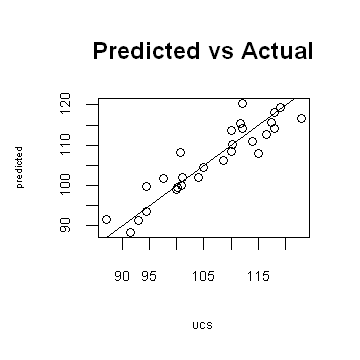

In [336]:
options(repr.plot.width=3, repr.plot.height=3)
plot(rocks_with_PCA[-c(11, 15),]$UCS, LOOcv_PC1_PC3_no11_no15$cvpred, xlab = 'UCS', ylab = 'predicted', 
     main = 'Predicted vs Actual',
    cex.lab = 0.5, cex.axis = 0.7)
abline(a = 0, b= 1) # add reference line for predicted = actual

## Models without PCA

Most of the variables contribute to PC1 and PC3 so it is a bit difficult to interpret what they mean.
There is too much multicolinearity to bother trying models with all of the
available variables but since a few of the variables are highly correlation with the dependent variable, I am wondering if maybe a simple model with 1 or 2 of the variables might compare favourably with the model built using PC1 + PC3. Such a model would have the advantage of being very straight forward and understandable so some compromise on performance might be acceptable.

In [337]:
#Best Subset with max 3 variables (no point going higher, too much correlation)
library(leaps)
best_subset <- regsubsets(UCS~., data = rocks, nvmax = 3)
summary(best_subset)

Subset selection object
Call: regsubsets.formula(UCS ~ ., data = rocks, nvmax = 3)
7 Variables  (and intercept)
       Forced in Forced out
quartz     FALSE      FALSE
plag       FALSE      FALSE
kfds       FALSE      FALSE
hb         FALSE      FALSE
gs         FALSE      FALSE
sf         FALSE      FALSE
ar         FALSE      FALSE
1 subsets of each size up to 3
Selection Algorithm: exhaustive
         quartz plag kfds hb  gs  sf  ar 
1  ( 1 ) " "    " "  " "  " " "*" " " " "
2  ( 1 ) "*"    " "  " "  " " "*" " " " "
3  ( 1 ) "*"    " "  " "  " " "*" "*" " "

This output tells me that the best model with one predictor uses 'gs', the best with two predictors uses 'gs' and 'quartz' and the best predictor with three variables uses 'gs', 'quartz' and 'sf'

In [338]:
cor(rocks[c("gs", "quartz", "sf")])

,gs,quartz,sf
gs,1.000,-0.340,-0.668
quartz,-0.340,1.000,0.217
sf,-0.668,0.217,1.000


But 'gs' and 'sf' are correlated (-0.668) and so only the 1 and 2 variable solutions were trialed. The same procedure as above was followed and the best performing model was found to be 'gs' + 'quartz' with observation 15 removed.

In [339]:
model_gs_quartz_no15 <- lm(UCS ~ gs + quartz, data = rocks[-15,])
summary(model_gs_quartz_no15)
options(repr.plot.width=7, repr.plot.height=3)
par(mfrow = c(1,2))
#plot(model_gs_quartz_no15)
LOOcv_gs_quartz_no15= cv.lm(rocks[-15,], model_gs_quartz_no15, m =29, printit = FALSE, plotit = FALSE)
RMSD_gs_quartz_no15<-func_RMSD(LOOcv_gs_quartz_no15)



Call:
lm(formula = UCS ~ gs + quartz, data = rocks[-15, ])

Residuals:
   Min     1Q Median     3Q    Max 
-7.345 -3.006 -0.018  2.886 10.109 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  113.970      8.246   13.82  1.7e-13 ***
gs          -799.726     84.492   -9.47  6.6e-10 ***
quartz         0.466      0.170    2.74    0.011 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.57 on 26 degrees of freedom
Multiple R-squared:  0.836,	Adjusted R-squared:  0.823 
F-statistic: 66.1 on 2 and 26 DF,  p-value: 6.33e-11


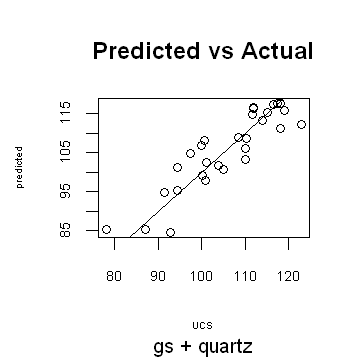

In [340]:
options(repr.plot.width=3, repr.plot.height=3)
plot(rocks[-15,]$UCS, LOOcv_gs_quartz_no15$cvpred, xlab = 'UCS', ylab = 'predicted', 
     main = 'Predicted vs Actual',
     sub = "gs + quartz",
    cex.lab = 0.5, cex.axis = 0.7)
abline(a = 0, b= 1) # add reference line for predicted = actual

In [341]:
#add the paramters for the gs + quartz' model to the model comparison data frame
gs_quartz <- c(summary(model_gs_quartz_no15)$r.squared, summary(model_gs_quartz_no15)$sigma, RMSD_gs_quartz_no15 )
model_comparison <- rbind(model_comparison, gs_quartz)
rownames(model_comparison)[5] <- "gs and quartz"
model_comparison

,adj_r2,RSE,RMSD_all
pca all,0.861,4.13,4.37
pca no 15,0.900,3.57,3.82
pca no 11,0.830,4.06,4.27
pca no 11 and 15,0.878,3.50,3.73
gs and quartz,0.836,4.57,4.80


The performance of the PC1 + PC3 model is better but depending on how the model is intended on being used, it may be preferrable to chose the model based on 'gs' and 'quartz' to improve understandability.